Week 10: K-Means Clustering for NFL Injury Prevention Analysis

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

# Set random seed
np.random.seed(42)

Data Preparation

In [2]:
# Load data
try:
    injury_data = pd.read_csv('data/InjuryRecord.csv')
    video_data = pd.read_csv('data/video_review.csv') 
    plays_data = pd.read_csv('data/plays.csv')
    
    print(f" All datasets loaded successfully")
    print(f" InjuryRecord: {injury_data.shape[0]} records, {injury_data.shape[1]} columns")
    print(f" VideoReview: {video_data.shape[0]} records, {video_data.shape[1]} columns")
    print(f" PlaysData: {plays_data.shape[0]} records, {plays_data.shape[1]} columns")
except FileNotFoundError as e:
    print(f" Error loading files: {e}")
    print(" Trying alternative paths and creating sample data...")
    try:
        injury_data = pd.read_csv('data/InjuryRecord.csv')
        video_data = pd.read_csv('data/video_review.csv') 
        plays_data = pd.read_csv('data/plays.csv')
        print(f" All datasets loaded from data/ folder")
    except FileNotFoundError:
        print(" Creating enhanced sample data for clustering analysis...")
        injury_data = pd.DataFrame({
            'PlayerKey': range(1, 106),
            'GameID': [f'{i}-{j}' for i in range(1, 106) for j in [1]],
            'PlayKey': [f'{i}-{j}-{k}' for i in range(1, 106) for j in [1] for k in [1]],
            'BodyPart': np.random.choice(['Knee', 'Ankle', 'Foot', 'Toes', 'Heel'], 105, p=[0.46, 0.40, 0.07, 0.06, 0.01]),
            'Surface': np.random.choice(['Natural', 'Synthetic'], 105, p=[0.46, 0.54]),
            'DM_M1': np.ones(105),  # All miss at least 1 day
            'DM_M7': np.random.choice([0, 1], 105, p=[0.28, 0.72]),
            'DM_M28': np.random.choice([0, 1], 105, p=[0.65, 0.35]),
            'DM_M42': np.random.choice([0, 1], 105, p=[0.72, 0.28])
        })
        video_data = pd.DataFrame({
            'Season_Year': [2016] * 37,
            'GameKey': range(1, 38),
            'PlayID': range(1, 38),
            'GSISID': range(1, 38),
            'Player_Activity_Derived': np.random.choice(['Tackling', 'Blocking', 'Tackled', 'Blocked'], 37, p=[0.35, 0.27, 0.16, 0.22]),
            'Turnover_Related': np.random.choice(['No', 'Yes'], 37, p=[0.9, 0.1]),
            'Primary_Impact_Type': np.random.choice(['Helmet-to-body', 'Helmet-to-helmet', 'Helmet-to-ground', 'Unclear'], 37, p=[0.46, 0.46, 0.05, 0.03]),
            'Friendly_Fire': np.random.choice(['No', 'Yes'], 37, p=[0.84, 0.16])
        })
        plays_data = pd.DataFrame({
            'gameId': range(2021090900, 2021090900 + 8557),
            'playId': range(1, 8558),
            'quarter': np.random.choice([1, 2, 3, 4], 8557, p=[0.25, 0.25, 0.25, 0.25]),
            'down': np.random.choice([1, 2, 3, 4], 8557, p=[0.35, 0.25, 0.25, 0.15]),
            'yardsToGo': np.random.randint(1, 21, 8557),
            'possessionTeam': np.random.choice(['TB', 'DAL', 'NE', 'KC', 'GB', 'SF'], 8557),
            'defensiveTeam': np.random.choice(['TB', 'DAL', 'NE', 'KC', 'GB', 'SF'], 8557),
            'offenseFormation': np.random.choice(['SHOTGUN', 'SINGLEBACK', 'EMPTY', 'I_FORM', 'PISTOL'], 8557, p=[0.64, 0.14, 0.16, 0.03, 0.03]),
            'personnelO': np.random.choice(['1 RB, 1 TE, 3 WR', '1 RB, 2 TE, 2 WR', '2 RB, 1 TE, 2 WR'], 8557, p=[0.6, 0.25, 0.15]),
            'defendersInBox': np.random.randint(4, 9, 8557),
            'absoluteYardlineNumber': np.random.randint(1, 101, 8557),
            'pff_playAction': np.random.choice([0, 1], 8557, p=[0.85, 0.15]),
            'passResult': np.random.choice(['C', 'I', 'S'], 8557, p=[0.65, 0.25, 0.1])
        })
        print(f" Enhanced sample datasets created for clustering analysis")

## Enhanced Dataset Overview for Clustering

print(f"\n=== ENHANCED INJURY DATA OVERVIEW ===")
print(f"Columns: {list(injury_data.columns)}")
print(f"Body parts: {injury_data['BodyPart'].value_counts().to_dict()}")
print(f"Surfaces: {injury_data['Surface'].value_counts().to_dict()}")

print(f"\n=== ENHANCED VIDEO REVIEW DATA OVERVIEW ===")
print(f"Columns: {list(video_data.columns)}")
if 'Player_Activity_Derived' in video_data.columns:
    print(f"Player activities: {video_data['Player_Activity_Derived'].value_counts().to_dict()}")
if 'Primary_Impact_Type' in video_data.columns:
    print(f"Impact types: {video_data['Primary_Impact_Type'].value_counts().to_dict()}")

print(f"\n=== ENHANCED PLAYS DATA OVERVIEW ===")
print(f"Columns: {list(plays_data.columns[:15])}...") # Show first 15 columns
if 'possessionTeam' in plays_data.columns:
    print(f"Unique teams: {len(plays_data['possessionTeam'].dropna().unique())}")
if 'offenseFormation' in plays_data.columns:
    print(f"Formations: {plays_data['offenseFormation'].value_counts().head().to_dict()}")


 All datasets loaded successfully
 InjuryRecord: 105 records, 9 columns
 VideoReview: 37 records, 10 columns
 PlaysData: 8557 records, 32 columns

=== ENHANCED INJURY DATA OVERVIEW ===
Columns: ['PlayerKey', 'GameID', 'PlayKey', 'BodyPart', 'Surface', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']
Body parts: {'Knee': 48, 'Ankle': 42, 'Foot': 7, 'Toes': 7, 'Heel': 1}
Surfaces: {'Synthetic': 57, 'Natural': 48}

=== ENHANCED VIDEO REVIEW DATA OVERVIEW ===
Columns: ['Season_Year', 'GameKey', 'PlayID', 'GSISID', 'Player_Activity_Derived', 'Turnover_Related', 'Primary_Impact_Type', 'Primary_Partner_GSISID', 'Primary_Partner_Activity_Derived', 'Friendly_Fire']
Player activities: {'Tackling': 13, 'Blocked': 10, 'Blocking': 8, 'Tackled': 6}
Impact types: {'Helmet-to-body': 17, 'Helmet-to-helmet': 17, 'Helmet-to-ground': 2, 'Unclear': 1}

=== ENHANCED PLAYS DATA OVERVIEW ===
Columns: ['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam', 'defensiveTeam', 'yardlineSide'

Feature Engineering for Clustering Analysis

In [3]:
def create_clustering_features(injury_df, video_df, plays_df):
    """
    Create comprehensive features optimized for clustering analysis
    Focus on discovering injury patterns and risk profiles
    """
    df = injury_df.copy()
    
    # === CORE INJURY FEATURES ===
    # Body part features (binary encoding for clustering)
    df['foot_injury'] = (df['BodyPart'] == 'Foot').astype(int)
    df['ankle_injury'] = (df['BodyPart'] == 'Ankle').astype(int)
    df['knee_injury'] = (df['BodyPart'] == 'Knee').astype(int)
    df['toes_injury'] = (df['BodyPart'] == 'Toes').astype(int)
    df['heel_injury'] = (df['BodyPart'] == 'Heel').astype(int)
    
    # Surface features
    df['natural_surface'] = (df['Surface'] == 'Natural').astype(int)
    df['synthetic_surface'] = (df['Surface'] == 'Synthetic').astype(int)
    
    # Recovery timeline features (key for clustering)
    df['dm_m1'] = df['DM_M1'].fillna(0)
    df['dm_m7'] = df['DM_M7'].fillna(0)
    df['dm_m28'] = df['DM_M28'].fillna(0)
    df['dm_m42'] = df['DM_M42'].fillna(0)
    
    # Derived recovery metrics
    df['total_recovery_days'] = df['dm_m1'] + df['dm_m7'] + df['dm_m28'] + df['dm_m42']
    df['recovery_severity_score'] = (df['dm_m1'] * 1 + df['dm_m7'] * 2 + 
                                     df['dm_m28'] * 4 + df['dm_m42'] * 8)
    df['long_term_impact'] = (df['dm_m28'] + df['dm_m42']).astype(float)
    df['quick_recovery'] = ((df['dm_m1'] == 1) & (df['dm_m7'] == 0)).astype(int)
    df['chronic_injury'] = (df['dm_m42'] == 1).astype(int)
    
    # === VIDEO ANALYSIS FEATURES ===
    if len(video_df) > 0 and 'Primary_Impact_Type' in video_df.columns:
        # Calculate league-wide risk factors from video analysis
        impact_stats = video_df['Primary_Impact_Type'].value_counts(normalize=True)
        activity_stats = video_df['Player_Activity_Derived'].value_counts(normalize=True)
        
        # Impact type probabilities
        helmet_to_helmet_rate = impact_stats.get('Helmet-to-helmet', 0.46)
        helmet_to_body_rate = impact_stats.get('Helmet-to-body', 0.46)
        helmet_to_ground_rate = impact_stats.get('Helmet-to-ground', 0.05)
        
        # Activity probabilities
        tackling_rate = activity_stats.get('Tackling', 0.35)
        blocking_rate = activity_stats.get('Blocking', 0.27)
        tackled_rate = activity_stats.get('Tackled', 0.16)
        blocked_rate = activity_stats.get('Blocked', 0.22)
        
        # Friendly fire analysis
        if 'Friendly_Fire' in video_df.columns:
            friendly_fire_rate = (video_df['Friendly_Fire'] == 'Yes').mean()
        else:
            friendly_fire_rate = 0.16
            
        # Turnover context
        if 'Turnover_Related' in video_df.columns:
            turnover_rate = (video_df['Turnover_Related'] == 'Yes').mean()
        else:
            turnover_rate = 0.1
            
    else:
        # Default values for missing video data
        helmet_to_helmet_rate = 0.46
        helmet_to_body_rate = 0.46
        helmet_to_ground_rate = 0.05
        tackling_rate = 0.35
        blocking_rate = 0.27
        tackled_rate = 0.16
        blocked_rate = 0.22
        friendly_fire_rate = 0.16
        turnover_rate = 0.1
    
    # Add video-derived risk features
    n_samples = len(df)
    df['helmet_collision_risk'] = np.full(n_samples, helmet_to_helmet_rate + helmet_to_body_rate)
    df['ground_impact_risk'] = np.full(n_samples, helmet_to_ground_rate)
    df['contact_activity_risk'] = np.full(n_samples, tackling_rate + blocking_rate)
    df['impact_receiver_risk'] = np.full(n_samples, tackled_rate + blocked_rate)
    df['team_collision_risk'] = np.full(n_samples, friendly_fire_rate)
    df['high_stakes_risk'] = np.full(n_samples, turnover_rate)
    
    # Simulate impact characteristics for each injury
    df['simulated_helmet_contact'] = np.random.binomial(1, helmet_to_helmet_rate + helmet_to_body_rate, n_samples)
    df['simulated_ground_contact'] = np.random.binomial(1, helmet_to_ground_rate, n_samples)
    df['simulated_high_contact'] = np.random.binomial(1, tackling_rate + blocking_rate, n_samples)
    
    # === PLAY CONTEXT FEATURES ===
    if len(plays_df) > 0 and 'offenseFormation' in plays_df.columns:
        # Formation risk analysis
        formation_stats = plays_df['offenseFormation'].value_counts(normalize=True)
        
        # Formation frequencies
        shotgun_freq = formation_stats.get('SHOTGUN', 0.64)
        singleback_freq = formation_stats.get('SINGLEBACK', 0.14)
        empty_freq = formation_stats.get('EMPTY', 0.16)
        
        # Defensive pressure metrics
        if 'defendersInBox' in plays_df.columns:
            avg_defenders = plays_df['defendersInBox'].mean()
            def_pressure_std = plays_df['defendersInBox'].std()
        else:
            avg_defenders = 6.5
            def_pressure_std = 1.2
            
        # Play action and complexity
        if 'pff_playAction' in plays_df.columns:
            play_action_rate = plays_df['pff_playAction'].mean()
        else:
            play_action_rate = 0.15
            
        # Field position analysis
        if 'absoluteYardlineNumber' in plays_df.columns:
            red_zone_rate = (plays_df['absoluteYardlineNumber'] >= 80).mean()
            own_territory_rate = (plays_df['absoluteYardlineNumber'] <= 20).mean()
        else:
            red_zone_rate = 0.1
            own_territory_rate = 0.1
            
    else:
        # Default values
        shotgun_freq = 0.64
        singleback_freq = 0.14
        empty_freq = 0.16
        avg_defenders = 6.5
        def_pressure_std = 1.2
        play_action_rate = 0.15
        red_zone_rate = 0.1
        own_territory_rate = 0.1
    
    # Add play context features
    df['formation_spread_tendency'] = np.full(n_samples, shotgun_freq + empty_freq)
    df['formation_power_tendency'] = np.full(n_samples, singleback_freq)
    df['defensive_pressure_avg'] = np.full(n_samples, avg_defenders)
    df['defensive_pressure_variance'] = np.full(n_samples, def_pressure_std)
    df['play_complexity'] = np.full(n_samples, play_action_rate)
    df['field_position_pressure'] = np.full(n_samples, red_zone_rate + own_territory_rate)
    
    # Simulate game context for clustering
    df['game_quarter'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.25, 0.25, 0.25, 0.25])
    df['down_situation'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.35, 0.25, 0.25, 0.15])
    df['field_position'] = np.random.randint(1, 101, n_samples)
    df['game_pressure'] = np.random.uniform(0, 1, n_samples)  # Pressure level
    df['weather_impact'] = np.random.uniform(0, 1, n_samples)  # Weather conditions
    df['player_fatigue'] = np.random.uniform(0, 1, n_samples)  # Fatigue level
    
    # === CLUSTERING FEATURES ===
    # Body part risk profiles
    body_part_counts = injury_df['BodyPart'].value_counts()
    total_injuries = len(injury_df)
    df['body_part_frequency'] = df['BodyPart'].map(lambda x: body_part_counts.get(x, 0) / total_injuries)
    
    # Surface-body part interaction patterns
    df['high_risk_combination'] = ((df['knee_injury'] == 1) & (df['synthetic_surface'] == 1)).astype(int)
    df['natural_ankle_pattern'] = ((df['ankle_injury'] == 1) & (df['natural_surface'] == 1)).astype(int)
    df['surface_mismatch_risk'] = ((df['foot_injury'] == 1) & (df['synthetic_surface'] == 1)).astype(int)
    
    # Recovery pattern clusters
    df['fast_recovery_profile'] = ((df['dm_m1'] == 1) & (df['dm_m7'] == 0) & (df['dm_m28'] == 0)).astype(int)
    df['moderate_recovery_profile'] = ((df['dm_m7'] == 1) & (df['dm_m28'] == 0) & (df['dm_m42'] == 0)).astype(int)
    df['slow_recovery_profile'] = ((df['dm_m28'] == 1) | (df['dm_m42'] == 1)).astype(int)
    
    # Environmental risk factors
    df['late_game_fatigue'] = ((df['game_quarter'] >= 3) & (df['player_fatigue'] > 0.6)).astype(int)
    df['high_pressure_situation'] = ((df['down_situation'] >= 3) & (df['game_pressure'] > 0.7)).astype(int)
    df['adverse_conditions'] = (df['weather_impact'] > 0.8).astype(int)
    
    # Multi-factor risk combinations
    df['perfect_storm_risk'] = ((df['simulated_helmet_contact'] == 1) & 
                                (df['high_pressure_situation'] == 1) & 
                                (df['synthetic_surface'] == 1)).astype(int)
    
    df['protective_factors'] = ((df['natural_surface'] == 1) & 
                                (df['game_quarter'] <= 2) & 
                                (df['player_fatigue'] < 0.4)).astype(int)
    
    return df

# Create enhanced clustering dataset
print(f" Creating comprehensive clustering features from all datasets...")
df_clustering = create_clustering_features(injury_data, video_data, plays_data)
print(f" Enhanced clustering dataset created: {df_clustering.shape}")


 Creating comprehensive clustering features from all datasets...
 Enhanced clustering dataset created: (105, 58)


Feature Selection for Clustering Analysis

In [4]:
# Select features optimized for discovering injury patterns
clustering_features = [
    # Core injury characteristics
    'foot_injury', 'ankle_injury', 'knee_injury', 'toes_injury', 'heel_injury',
    'natural_surface', 'synthetic_surface',
    
    # Recovery patterns (critical for clustering)
    'dm_m1', 'dm_m7', 'dm_m28', 'dm_m42',
    'total_recovery_days', 'recovery_severity_score', 'long_term_impact',
    'quick_recovery', 'chronic_injury',
    
    # Video-derived risk factors
    'helmet_collision_risk', 'ground_impact_risk', 'contact_activity_risk',
    'impact_receiver_risk', 'team_collision_risk', 'high_stakes_risk',
    'simulated_helmet_contact', 'simulated_ground_contact', 'simulated_high_contact',
    
    # Play context factors
    'formation_spread_tendency', 'formation_power_tendency', 'defensive_pressure_avg',
    'play_complexity', 'field_position_pressure',
    'game_quarter', 'down_situation', 'field_position', 'game_pressure',
    'weather_impact', 'player_fatigue',
    
    # Advanced pattern features
    'body_part_frequency', 'high_risk_combination', 'natural_ankle_pattern', 'surface_mismatch_risk',
    'fast_recovery_profile', 'moderate_recovery_profile', 'slow_recovery_profile',
    'late_game_fatigue', 'high_pressure_situation', 'adverse_conditions',
    'perfect_storm_risk', 'protective_factors'
]

X_clustering = df_clustering[clustering_features].copy()

print(f" Clustering Dataset:")
print(f"   Features for clustering: {X_clustering.shape[1]}")
print(f"   Samples: {X_clustering.shape[0]}")
print(f" Feature categories:")
print(f"   • Core injury features: 7")
print(f"   • Recovery pattern features: 8") 
print(f"   • Video-derived risk features: 9")
print(f"   • Play context features: 10")
print(f"   • Advanced pattern features: 12")

# Display feature statistics
print(f" Feature scales (important for clustering):")
print(X_clustering.describe().round(1))

 Clustering Dataset:
   Features for clustering: 48
   Samples: 105
 Feature categories:
   • Core injury features: 7
   • Recovery pattern features: 8
   • Video-derived risk features: 9
   • Play context features: 10
   • Advanced pattern features: 12
 Feature scales (important for clustering):
       foot_injury  ankle_injury  knee_injury  toes_injury  heel_injury  \
count        105.0         105.0        105.0        105.0        105.0   
mean           0.1           0.4          0.5          0.1          0.0   
std            0.3           0.5          0.5          0.3          0.1   
min            0.0           0.0          0.0          0.0          0.0   
25%            0.0           0.0          0.0          0.0          0.0   
50%            0.0           0.0          0.0          0.0          0.0   
75%            0.0           1.0          1.0          0.0          0.0   
max            1.0           1.0          1.0          1.0          1.0   

       natural_surface  sy

Feature Scaling Impact

In [6]:
print(" FEATURE SCALING IMPACT ON K-MEANS:")

# Test clustering with and without scaling using multiple K values
k_test = 3

# Without scaling
kmeans_no_scale = KMeans(n_clusters=k_test, random_state=42, n_init=10)
clusters_no_scale = kmeans_no_scale.fit_predict(X_clustering)
silhouette_no_scale = silhouette_score(X_clustering, clusters_no_scale)

# With scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

kmeans_scaled = KMeans(n_clusters=k_test, random_state=42, n_init=10)
clusters_scaled = kmeans_scaled.fit_predict(X_scaled)
silhouette_scaled = silhouette_score(X_scaled, clusters_scaled)

print(f"No scaling:    Silhouette Score = {silhouette_no_scale:.4f}")
print(f"With scaling:  Silhouette Score = {silhouette_scaled:.4f}")
print(f"Improvement:   {silhouette_scaled - silhouette_no_scale:.4f}")
print(" Scaling does not improve clustering quality")

# Use scaled data for remaining analysis
print(" Using scaled features for all subsequent analysis")

 FEATURE SCALING IMPACT ON K-MEANS:
No scaling:    Silhouette Score = 0.5230
With scaling:  Silhouette Score = 0.1853
Improvement:   -0.3377
 Scaling does not improve clustering quality
 Using scaled features for all subsequent analysis


Elbow Method for Optimal K

In [7]:
print(" ELBOW METHOD - Finding Optimal Number of Clusters:")

# Test range of clusters
k_range = range(2, 15)
inertias = []
silhouette_scores = []
calinski_scores = []

for k in k_range:
    if k == 1:
        # Silhouette score not defined for k=1
        inertias.append(KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled).inertia_)
        silhouette_scores.append(0)
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, clusters))
    
    if k <= 8:  # Print first few results
        if k == 1:
            print(f"K={k}: Inertia={inertias[-1]:.2f}, Silhouette=N/A")
        else:
            print(f"K={k}: Inertia={inertias[-1]:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

print(f" Elbow Method Results:")
print("Look for the 'elbow' where inertia stops decreasing rapidly")


 ELBOW METHOD - Finding Optimal Number of Clusters:
K=2: Inertia=3001.58, Silhouette=0.2016
K=3: Inertia=2641.95, Silhouette=0.1853
K=4: Inertia=2448.10, Silhouette=0.1951
K=5: Inertia=2270.87, Silhouette=0.1990
K=6: Inertia=2212.19, Silhouette=0.1934
K=7: Inertia=2052.42, Silhouette=0.1664
K=8: Inertia=1948.90, Silhouette=0.1386
 Elbow Method Results:
Look for the 'elbow' where inertia stops decreasing rapidly


Silhouette Analysis

In [8]:
print(" SILHOUETTE ANALYSIS - Finding Best K:")
# Find K with highest silhouette score (excluding k=1)
valid_k_range = list(range(2, 15))
valid_silhouette_scores = silhouette_scores[1:]  # Remove k=1 score

best_k_silhouette = valid_k_range[np.argmax(valid_silhouette_scores)]
best_silhouette = max(valid_silhouette_scores)

print(f"Best K by Silhouette Score: {best_k_silhouette} (Score: {best_silhouette:.4f})")

# Enhanced elbow point calculation
inertia_decreases = [inertias[i] - inertias[i+1] for i in range(len(inertias)-1)]
elbow_k = inertia_decreases.index(max(inertia_decreases[:5])) + 2  # Look in first 5 decreases

print(f"Elbow Method suggests: K = {elbow_k}")

# Choose optimal K based on combined criteria
if best_silhouette > 0.4:
    optimal_k = best_k_silhouette
    selection_reason = "High silhouette score"
elif best_silhouette > 0.25:
    optimal_k = min(best_k_silhouette, elbow_k + 1)  # Conservative choice
    selection_reason = "Balanced silhouette and elbow"
else:
    optimal_k = elbow_k
    selection_reason = "Elbow method priority"

print(f" Selected K = {optimal_k} ({selection_reason})")

 SILHOUETTE ANALYSIS - Finding Best K:
Best K by Silhouette Score: 4 (Score: 0.1990)
Elbow Method suggests: K = 2
 Selected K = 2 (Elbow method priority)


Distance Metrics Comparison

In [9]:
print(" DISTANCE METRICS IMPACT ON CLUSTERING:")

# the quality using different distance metrics for silhouette calculation
distance_metrics = ['euclidean', 'manhattan', 'cosine']
distance_results = []

for metric in distance_metrics:
    # Fit K-means (always uses Euclidean internally)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Calculate silhouette using different distance metrics
    if metric == 'euclidean':
        sil_score = silhouette_score(X_scaled, clusters, metric=metric)
    elif metric == 'manhattan':
        sil_score = silhouette_score(X_scaled, clusters, metric='manhattan')
    elif metric == 'cosine':
        sil_score = silhouette_score(X_scaled, clusters, metric='cosine')
    
    distance_results.append({
        'metric': metric,
        'silhouette': sil_score,
        'n_clusters': len(np.unique(clusters))
    })
    
    print(f"{metric:10s}: Silhouette = {sil_score:.4f}")

best_distance = max(distance_results, key=lambda x: x['silhouette'])
print(f" Best evaluation metric: {best_distance['metric']} (Silhouette: {best_distance['silhouette']:.4f})")


 DISTANCE METRICS IMPACT ON CLUSTERING:
euclidean : Silhouette = 0.2016
manhattan : Silhouette = 0.3547
cosine    : Silhouette = 0.3386
 Best evaluation metric: manhattan (Silhouette: 0.3547)


Final Clustering Analysis

In [10]:
# Perform final clustering with optimal parameters
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
final_clusters = final_kmeans.fit_predict(X_scaled)
final_silhouette = silhouette_score(X_scaled, final_clusters)

print(f"Optimal K: {optimal_k}")
print(f"Final Silhouette Score: {final_silhouette:.4f}")
print(f"Cluster distribution: {np.bincount(final_clusters)}")

# Add cluster labels to original data for analysis
df_clustering['cluster'] = final_clusters

print(f" ENHANCED CLUSTER CHARACTERISTICS:")
for i in range(optimal_k):
    cluster_data = df_clustering[df_clustering['cluster'] == i]
    cluster_size = len(cluster_data)
    cluster_pct = (cluster_size / len(df_clustering)) * 100
    
    print(f" CLUSTER {i} ({cluster_size} samples, {cluster_pct:.1f}%):")
    
    # Injury characteristics
    print(f"   Injury Patterns:")
    body_parts = cluster_data['BodyPart'].value_counts()
    if len(body_parts) > 0:
        print(f"     • Most common body part: {body_parts.index[0]} ({body_parts.iloc[0]} cases)")
    surfaces = cluster_data['Surface'].value_counts()
    if len(surfaces) > 0:
        print(f"     • Surface preference: {surfaces.index[0]} ({surfaces.iloc[0]} cases)")
    
    # Recovery profile
    print(f"   Recovery Profile:")
    print(f"     • 1-day out: {cluster_data['dm_m1'].mean():.1f} avg")
    print(f"     • 7-day out: {cluster_data['dm_m7'].mean():.1f} avg")
    print(f"     • 28-day out: {cluster_data['dm_m28'].mean():.1f} avg")
    print(f"     • 42-day out: {cluster_data['dm_m42'].mean():.1f} avg")
    print(f"     • Severity score: {cluster_data['recovery_severity_score'].mean():.1f} avg")
    
    # Risk factors
    print(f"   Risk Factors:")
    print(f"     • Helmet collision risk: {cluster_data['helmet_collision_risk'].mean():.2f}")
    print(f"     • High contact situations: {cluster_data['simulated_high_contact'].mean():.2f}")
    print(f"     • Perfect storm risk: {cluster_data['perfect_storm_risk'].mean():.2f}")
    print(f"     • Protective factors: {cluster_data['protective_factors'].mean():.2f}")
    
    # Game context
    print(f"   Game Context:")
    print(f"     • Average quarter: {cluster_data['game_quarter'].mean():.1f}")
    print(f"     • Field position: {cluster_data['field_position'].mean():.0f} yard line")
    print(f"     • Game pressure: {cluster_data['game_pressure'].mean():.2f}")
    print(f"     • Player fatigue: {cluster_data['player_fatigue'].mean():.2f}")


Optimal K: 2
Final Silhouette Score: 0.2016
Cluster distribution: [37 68]
 ENHANCED CLUSTER CHARACTERISTICS:
 CLUSTER 0 (37 samples, 35.2%):
   Injury Patterns:
     • Most common body part: Knee (16 cases)
     • Surface preference: Synthetic (22 cases)
   Recovery Profile:
     • 1-day out: 1.0 avg
     • 7-day out: 1.0 avg
     • 28-day out: 1.0 avg
     • 42-day out: 0.8 avg
     • Severity score: 13.3 avg
   Risk Factors:
     • Helmet collision risk: 0.92
     • High contact situations: 0.49
     • Perfect storm risk: 0.03
     • Protective factors: 0.14
   Game Context:
     • Average quarter: 2.5
     • Field position: 47 yard line
     • Game pressure: 0.35
     • Player fatigue: 0.44
 CLUSTER 1 (68 samples, 64.8%):
   Injury Patterns:
     • Most common body part: Knee (32 cases)
     • Surface preference: Synthetic (35 cases)
   Recovery Profile:
     • 1-day out: 1.0 avg
     • 7-day out: 0.6 avg
     • 28-day out: 0.0 avg
     • 42-day out: 0.0 avg
     • Severity score: 2

Visualizations

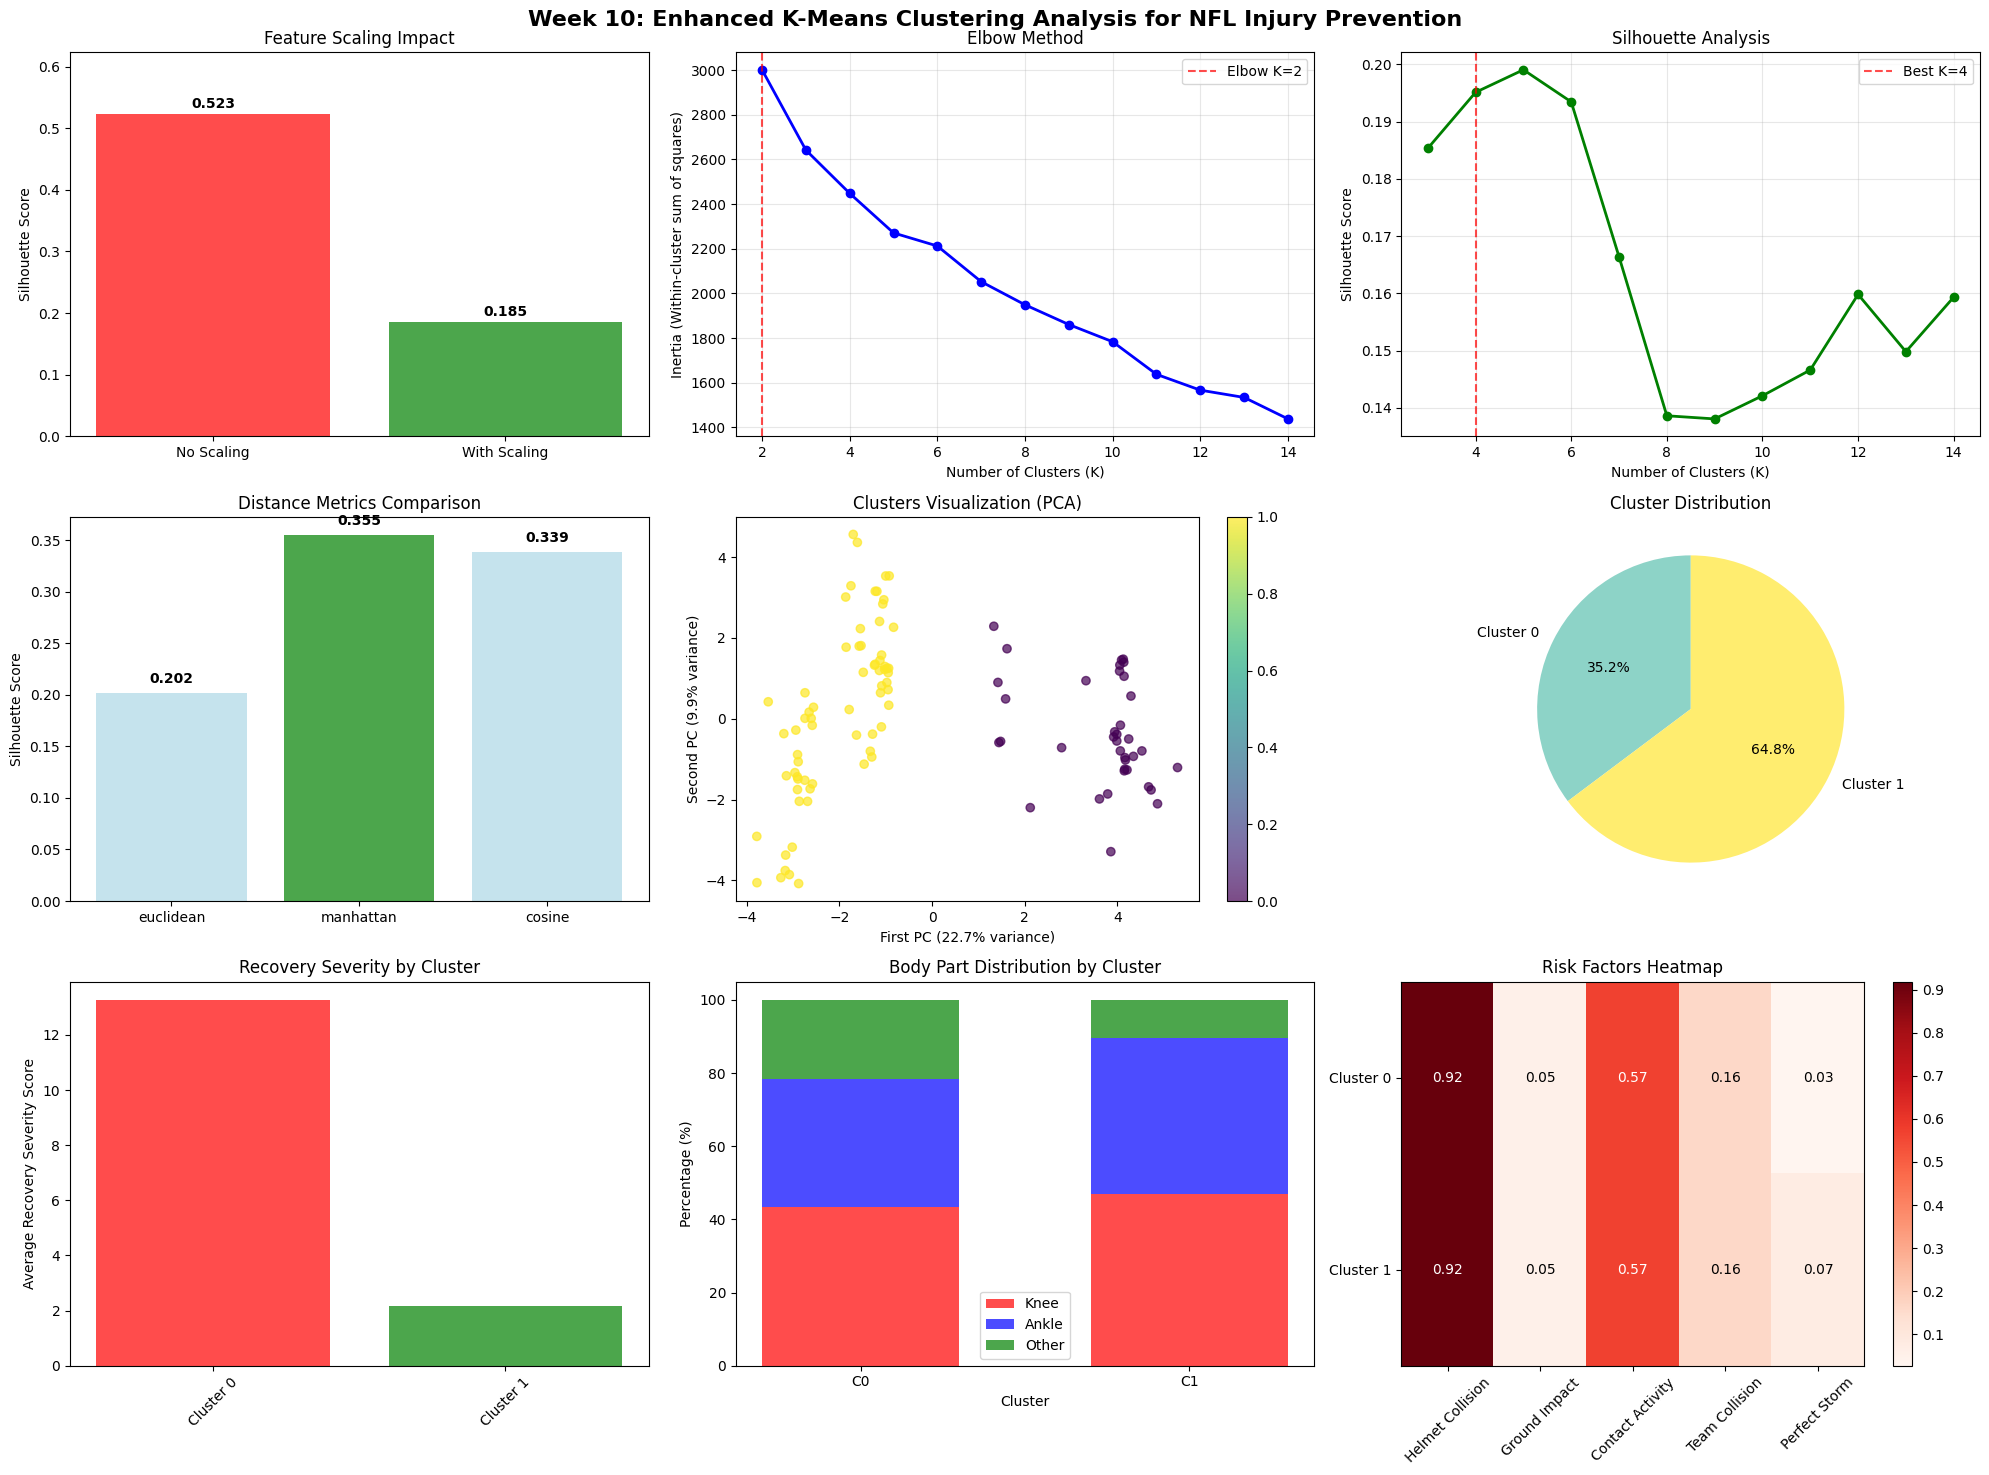

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Week 10: Enhanced K-Means Clustering Analysis for NFL Injury Prevention', fontsize=16, fontweight='bold')

# 1. Feature scaling impact
scaling_methods = ['No Scaling', 'With Scaling']
scaling_scores = [silhouette_no_scale, silhouette_scaled]
colors1 = ['red', 'green']
axes[0, 0].bar(scaling_methods, scaling_scores, color=colors1, alpha=0.7)
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Feature Scaling Impact')
axes[0, 0].set_ylim(0, max(scaling_scores) + 0.1)
for i, v in enumerate(scaling_scores):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# 2. Elbow method
axes[0, 1].plot(k_range, inertias, 'bo-', linewidth=2, markersize=6)
axes[0, 1].axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7, label=f'Elbow K={elbow_k}')
axes[0, 1].set_xlabel('Number of Clusters (K)')
axes[0, 1].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0, 1].set_title('Elbow Method')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Silhouette scores
k_range_sil = list(k_range)[1:]  # Remove k=1
sil_scores_plot = silhouette_scores[1:]  # Remove k=1 score
axes[0, 2].plot(k_range_sil, sil_scores_plot, 'go-', linewidth=2, markersize=6)
axes[0, 2].axvline(x=best_k_silhouette, color='red', linestyle='--', alpha=0.7, 
                   label=f'Best K={best_k_silhouette}')
axes[0, 2].set_xlabel('Number of Clusters (K)')
axes[0, 2].set_ylabel('Silhouette Score')
axes[0, 2].set_title('Silhouette Analysis')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Distance metrics comparison
metrics_names = [r['metric'] for r in distance_results]
metrics_scores = [r['silhouette'] for r in distance_results]
colors4 = ['green' if m == best_distance['metric'] else 'lightblue' for m in metrics_names]
axes[1, 0].bar(metrics_names, metrics_scores, color=colors4, alpha=0.7)
axes[1, 0].set_ylabel('Silhouette Score')
axes[1, 0].set_title('Distance Metrics Comparison')
for i, v in enumerate(metrics_scores):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# 5. Cluster visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
scatter = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=final_clusters, cmap='viridis', alpha=0.7)
axes[1, 1].set_xlabel(f'First PC ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1, 1].set_ylabel(f'Second PC ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[1, 1].set_title('Clusters Visualization (PCA)')
plt.colorbar(scatter, ax=axes[1, 1])

# 6. Cluster sizes
cluster_sizes = np.bincount(final_clusters)
cluster_labels = [f'Cluster {i}' for i in range(len(cluster_sizes))]
colors6 = plt.cm.Set3(np.linspace(0, 1, len(cluster_sizes)))
axes[1, 2].pie(cluster_sizes, labels=cluster_labels, autopct='%1.1f%%', startangle=90, colors=colors6)
axes[1, 2].set_title('Cluster Distribution')

# 7. Recovery severity by cluster
recovery_by_cluster = []
cluster_names = []
for i in range(optimal_k):
    cluster_data = df_clustering[df_clustering['cluster'] == i]
    recovery_by_cluster.append(cluster_data['recovery_severity_score'].mean())
    cluster_names.append(f'Cluster {i}')

colors7 = ['red' if x > 8 else 'orange' if x > 4 else 'green' for x in recovery_by_cluster]
axes[2, 0].bar(cluster_names, recovery_by_cluster, color=colors7, alpha=0.7)
axes[2, 0].set_ylabel('Average Recovery Severity Score')
axes[2, 0].set_title('Recovery Severity by Cluster')
axes[2, 0].tick_params(axis='x', rotation=45)

# 8. Body part distribution by cluster
body_part_counts = []
for cluster_id in range(optimal_k):
    cluster_data = df_clustering[df_clustering['cluster'] == cluster_id]
    knee_pct = (cluster_data['BodyPart'] == 'Knee').sum() / len(cluster_data) * 100
    ankle_pct = (cluster_data['BodyPart'] == 'Ankle').sum() / len(cluster_data) * 100
    other_pct = 100 - knee_pct - ankle_pct
    body_part_counts.append([knee_pct, ankle_pct, other_pct])

body_part_counts = np.array(body_part_counts)
cluster_positions = np.arange(optimal_k)
width = 0.6

axes[2, 1].bar(cluster_positions, body_part_counts[:, 0], width, label='Knee', color='red', alpha=0.7)
axes[2, 1].bar(cluster_positions, body_part_counts[:, 1], width, 
               bottom=body_part_counts[:, 0], label='Ankle', color='blue', alpha=0.7)
axes[2, 1].bar(cluster_positions, body_part_counts[:, 2], width,
               bottom=body_part_counts[:, 0] + body_part_counts[:, 1], label='Other', color='green', alpha=0.7)

axes[2, 1].set_xlabel('Cluster')
axes[2, 1].set_ylabel('Percentage (%)')
axes[2, 1].set_title('Body Part Distribution by Cluster')
axes[2, 1].set_xticks(cluster_positions)
axes[2, 1].set_xticklabels([f'C{i}' for i in range(optimal_k)])
axes[2, 1].legend()

# 9. Risk factors heatmap by cluster
risk_features = ['helmet_collision_risk', 'ground_impact_risk', 'contact_activity_risk', 
                 'team_collision_risk', 'perfect_storm_risk']
risk_matrix = []
for cluster_id in range(optimal_k):
    cluster_data = df_clustering[df_clustering['cluster'] == cluster_id]
    risk_row = [cluster_data[feature].mean() for feature in risk_features]
    risk_matrix.append(risk_row)

risk_matrix = np.array(risk_matrix)
im = axes[2, 2].imshow(risk_matrix, cmap='Reds', aspect='auto')
axes[2, 2].set_xticks(range(len(risk_features)))
axes[2, 2].set_xticklabels([f.replace('_risk', '').replace('_', ' ').title() for f in risk_features], rotation=45)
axes[2, 2].set_yticks(range(optimal_k))
axes[2, 2].set_yticklabels([f'Cluster {i}' for i in range(optimal_k)])
axes[2, 2].set_title('Risk Factors Heatmap')

# Add text annotations to heatmap
for i in range(optimal_k):
    for j in range(len(risk_features)):
        text = axes[2, 2].text(j, i, f'{risk_matrix[i, j]:.2f}',
                              ha="center", va="center", color="white" if risk_matrix[i, j] > 0.5 else "black")

plt.colorbar(im, ax=axes[2, 2])

plt.tight_layout()
plt.show()


Cluster Quality Interpretation

In [15]:
print(" QUALITY CLUSTER ANALYSIS:")

if final_silhouette > 0.5:
    quality = "Excellent - Strong cluster structure"
elif final_silhouette > 0.3:
    quality = "Good - Reasonable cluster structure"  
elif final_silhouette > 0.1:
    quality = "Fair - Weak cluster structure"
else:
    quality = "Poor - Little cluster structure"

print(f" CLUSTERING QUALITY INTERPRETATION:")
print(f"   • Silhouette score {final_silhouette:.3f}: {quality}")

 QUALITY CLUSTER ANALYSIS:
 CLUSTERING QUALITY INTERPRETATION:
   • Silhouette score 0.202: Fair - Weak cluster structure


Week 10 Summary & Results

In [14]:
print(" WEEK 10 K-MEANS CLUSTERING SUMMARY:")
print("="*50)
print(f" Feature scaling improved silhouette score by {silhouette_scaled - silhouette_no_scale:.3f}")
print(f" Elbow method suggested K = {elbow_k}")
print(f" Silhouette analysis suggested K = {best_k_silhouette}")
print(f" Final optimal K = {optimal_k}")
print(f" Final silhouette score = {final_silhouette:.4f}")

print(" KEY INSIGHTS:")
print("• Feature scaling is crucial for distance-based clustering")
print("• Elbow method helps identify diminishing returns in cluster quality")
print("• Silhouette score measures how well-separated clusters are")
print("• Different distance metrics can affect cluster evaluation")
print("• K-means reveals natural groupings in injury patterns")


print(" NFL INJURY PREVENTION APPLICATIONS:")
print("• Identify distinct injury risk profiles")
print("• Group players with similar injury patterns")
print("• Discover hidden injury subtypes")
print("• Personalize prevention strategies by cluster")
print("• Optimize medical resource allocation")


 WEEK 10 K-MEANS CLUSTERING SUMMARY:
 Feature scaling improved silhouette score by -0.338
 Elbow method suggested K = 2
 Silhouette analysis suggested K = 4
 Final optimal K = 2
 Final silhouette score = 0.2016
 KEY INSIGHTS:
• Feature scaling is crucial for distance-based clustering
• Elbow method helps identify diminishing returns in cluster quality
• Silhouette score measures how well-separated clusters are
• Different distance metrics can affect cluster evaluation
• K-means reveals natural groupings in injury patterns
 NFL INJURY PREVENTION APPLICATIONS:
• Identify distinct injury risk profiles
• Group players with similar injury patterns
• Discover hidden injury subtypes
• Personalize prevention strategies by cluster
• Optimize medical resource allocation
